# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [290]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
import helper
reload(helper)
from helper import clean_data

# magic word for producing visualizations in notebook
%matplotlib inline
np.random.seed(0)

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [255]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

In [256]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.shape

(891221, 85)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

#### Naturally Missing Data

In [257]:
missingvalues = dict()
for feature in feat_info["attribute"]:
    missingvalues[feature] = azdias[feature].isnull().sum()

In [258]:
df = pd.DataFrame(list(missingvalues.items()))
df.columns =["Features","Count"]

# sort df by Count column
df = df.sort_values(by=["Count"], ascending=False).reset_index(drop=True)

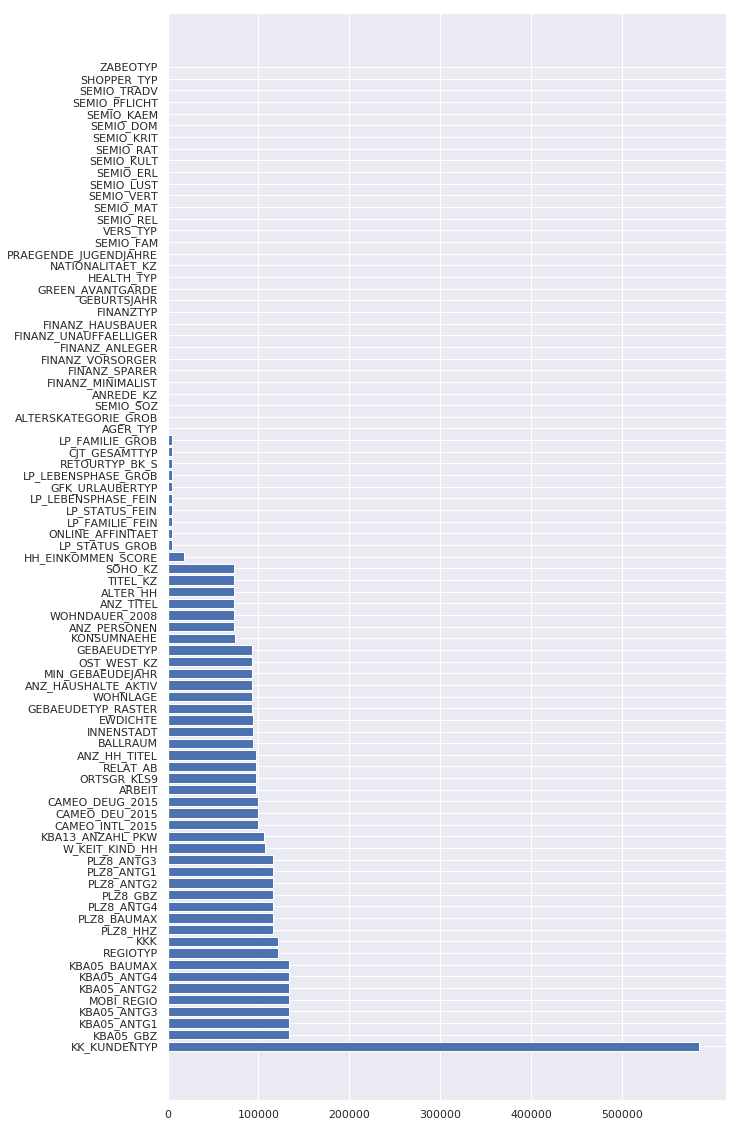

In [259]:
plt.figure(figsize=(10,20))
scalar_points = [*range(len(df["Features"].values))]
plt.barh(scalar_points, df["Count"].values)
plt.yticks(scalar_points, df["Features"].values)
plt.xticks(np.arange(min(df["Count"].values), max(df["Count"].values)+1, 100000))
plt.show()

#### Converting missing values to NaNs

In [260]:
missing_values = ['X', 'XX','-1','0', '9'] 
columns = feat_info['attribute'] 
list_missing_values_array = []

for missing_value_array in feat_info['missing_or_unknown']: 
    new_missing_array = [] 
    for i in missing_values: 
        if i in missing_value_array and i not in ['X', 'XX']: 
            new_missing_array.append(int(i))
        elif i in missing_value_array and i in ['X', 'XX']:
            new_missing_array.append(i)
    list_missing_values_array.append(new_missing_array)


for index, row in feat_info.iterrows():
    azdias[row["attribute"]].replace(list_missing_values_array[index], 
                                     [np.NaN]*len(list_missing_values_array[index]), 
                                     inplace=True)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [261]:
missingvalues = dict()
for feature in feat_info["attribute"]:
    missingvalues[feature] = azdias[feature].isnull().sum()

In [262]:
df = pd.DataFrame(list(missingvalues.items()))
df.columns =["Features","Count"]

# sort df by Count column
df = df.sort_values(by=["Count"], ascending=False).reset_index(drop=True)

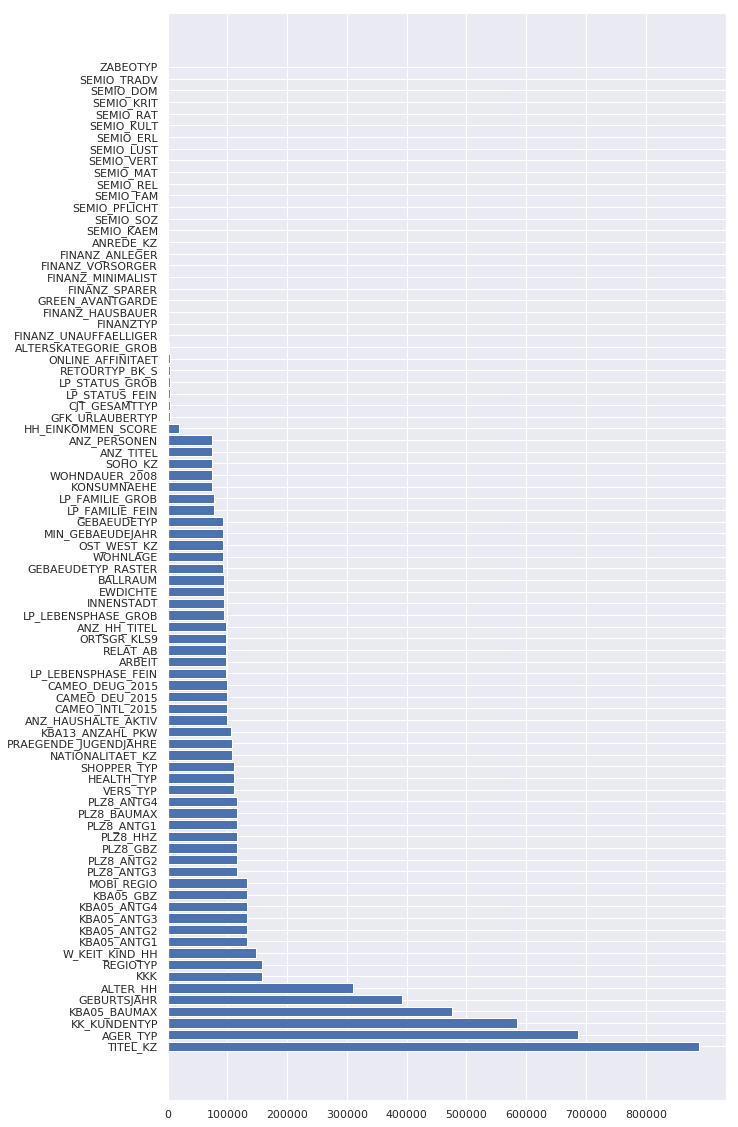

In [263]:
plt.figure(figsize=(10,20))
scalar_points = [*range(len(df["Features"].values))]
plt.barh(scalar_points, df["Count"].values)
plt.yticks(scalar_points, df["Features"].values)
plt.xticks(np.arange(min(df["Count"].values), max(df["Count"].values)+1, 100000))
plt.show()

#### Removing the outlier columns (First 6 in this case)

In [266]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias_dropped = azdias.drop(labels=df["Features"][:6].values, axis=1)

In [267]:
df["Features"][:6].values

array(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX',
       'GEBURTSJAHR', 'ALTER_HH'], dtype=object)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

Columns such as 'TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH' are clearly outliers in terms of proportion of missing data. 

There's a couple of groups of columns which share the same amount of missing data such as RR3 microcell features  which indicate the variance of number of families living in a building, in a microcell. Similarly, PLZ8 macrocell features share the same amount of missing data.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [268]:
# How much data is missing in each row of the dataset?
row_missing_values = azdias_dropped.isnull().sum(axis=1)

df_row_mv = pd.DataFrame(list(row_missing_values.values))
df_row_mv.columns =["Count_Row"]

# sort df by Count column
df_row_mv = df_row_mv.sort_values(by=["Count_Row"], ascending=False)

(array([6.97109e+05, 7.76340e+04, 1.28010e+04, 9.53300e+03, 8.29000e+02,
        1.55000e+02, 1.40160e+04, 5.03100e+03, 2.80380e+04, 4.60750e+04]),
 array([ 0. ,  4.9,  9.8, 14.7, 19.6, 24.5, 29.4, 34.3, 39.2, 44.1, 49. ]),
 <a list of 10 Patch objects>)

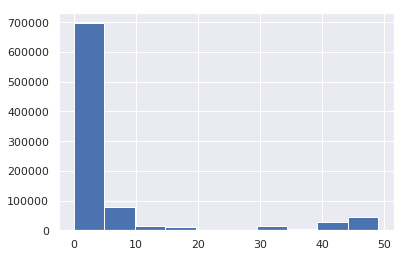

In [269]:
plt.hist(df_row_mv["Count_Row"].values)

In [270]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias_mv_l20 = azdias_dropped.drop(df_row_mv[df_row_mv["Count_Row"]>20].index)

In [271]:
azdias_mv_g20 = azdias_dropped.drop(df_row_mv[df_row_mv["Count_Row"]<20].index)

In [272]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# azdias_mv_g20 -> Rows which have more than 20 columns missing/NA
# azdias_mv_l20 -> Rows which have less than 20 columns missing/NA
print(azdias_mv_l20.shape)
print(azdias_mv_g20.shape)

(797426, 79)
(94144, 79)


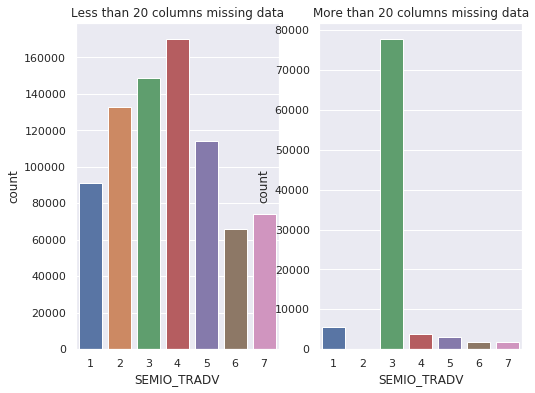

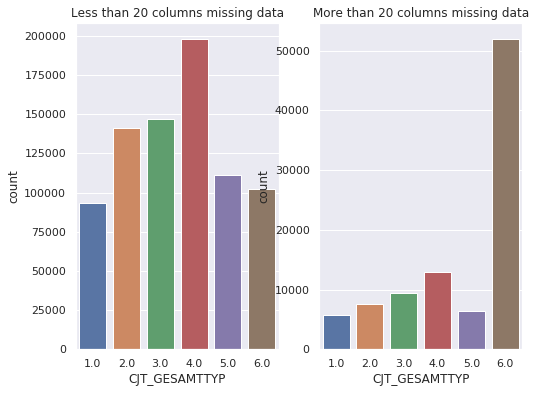

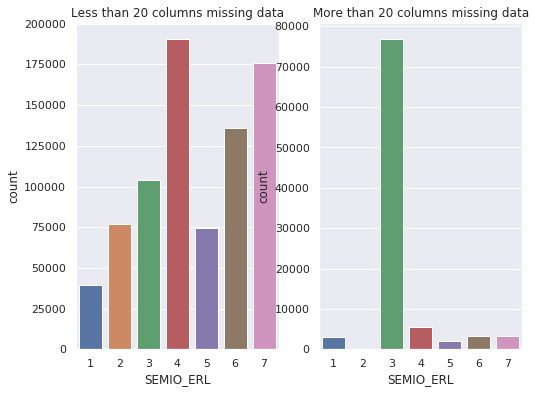

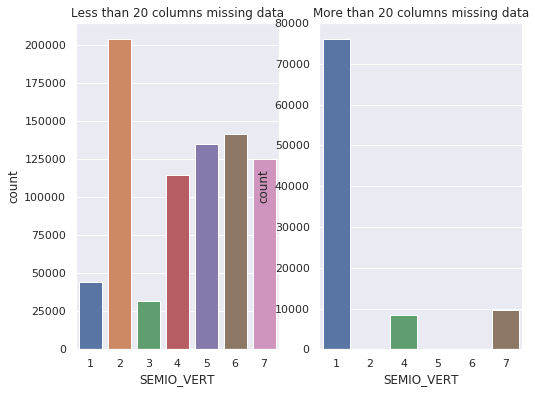

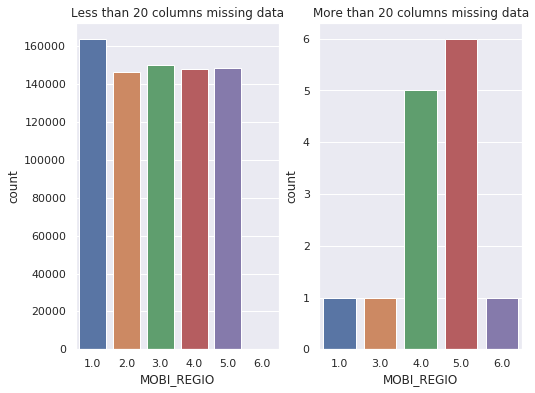

In [274]:
import random 
for i in random.sample(range(79), 5):
    plt.figure(figsize=(8,6))
    plt.subplot(1,2,1)
    sns.countplot(x = azdias_mv_l20.columns[i], data = azdias_mv_l20)
    plt.title('Less than 20 columns missing data')
    
    plt.subplot(1,2,2)
    sns.countplot(x = azdias_mv_g20.columns[i], data = azdias_mv_g20)
    plt.title('More than 20 columns missing data')

#### Discussion 1.1.3: Assess Missing Data in Each Row

The two data categories are significantly different in terms of quality and quantity. 

Extensive imputation will have to be performed on the missing values which will render the data synthetic and hence not authentic for purpose of analysis. If at all, it would aide in deviation of analysis on further scaling of such extensively imputed data and hence should be dropped from analysis. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [275]:
# For further convenience
azdias_cleaned = azdias_mv_l20

In [276]:
cleaned_features = azdias_cleaned.columns.values
feat_info_cleaned = feat_info[feat_info['attribute'].isin(cleaned_features)]

#### Number of features of each data type

In [277]:
type_counts = feat_info_cleaned['type'].value_counts()
type_counts

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

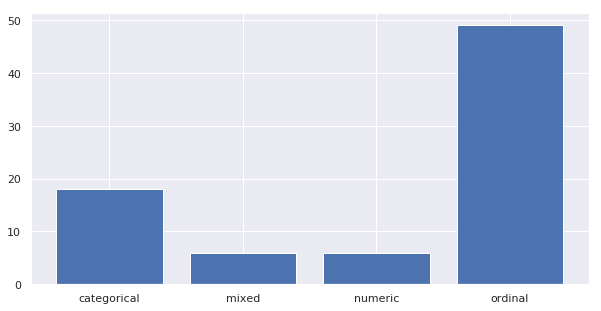

In [278]:
plt.figure(figsize=(10, 5))
scalar_points = [*range(len(feat_info_cleaned.groupby("type").count().index.values))]
plt.bar(scalar_points, feat_info_cleaned.groupby("type").count()["attribute"].values)
plt.xticks(scalar_points, feat_info_cleaned.groupby("type").count().index.values)
plt.show()

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

#### Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?



In [279]:
categoricals = list(feat_info_cleaned[feat_info_cleaned['type'] == 'categorical']['attribute'].values)
categoricals

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [280]:
azdias_categoricals = azdias_cleaned[categoricals].apply(lambda x: print(x.name, ':', x.unique()))

ANREDE_KZ : [2 1]
CJT_GESAMTTYP : [5.0 3.0 2.0 4.0 1.0 6.0 nan]
FINANZTYP : [1 6 5 2 4 3]
GFK_URLAUBERTYP : [10.0 1.0 5.0 12.0 9.0 3.0 8.0 11.0 4.0 2.0 7.0 6.0 nan]
GREEN_AVANTGARDE : [0 1]
LP_FAMILIE_FEIN : [5.0 1.0 nan 10.0 2.0 7.0 11.0 8.0 4.0 6.0 9.0 3.0]
LP_FAMILIE_GROB : [3.0 1.0 nan 5.0 2.0 4.0]
LP_STATUS_FEIN : [2.0 3.0 9.0 4.0 1.0 10.0 5.0 8.0 6.0 7.0 nan]
LP_STATUS_GROB : [1.0 2.0 4.0 5.0 3.0 nan]
NATIONALITAET_KZ : [1.0 3.0 2.0 nan]
SHOPPER_TYP : [3.0 2.0 1.0 0.0 nan]
SOHO_KZ : [1.0 0.0]
VERS_TYP : [2.0 1.0 nan]
ZABEOTYP : [5 3 4 1 6 2]
GEBAEUDETYP : [8.0 1.0 3.0 2.0 6.0 4.0 5.0]
OST_WEST_KZ : ['W' 'O']
CAMEO_DEUG_2015 : ['8' '4' '2' '6' '1' '9' '5' '7' nan '3']
CAMEO_DEU_2015 : ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' nan '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']


In [281]:
multi_categorical = list()
binary_categorical = list()
for category in categoricals:
    if len(azdias_cleaned[category].value_counts()) > 2:
        multi_categorical.append(category)
    else:
        binary_categorical.append(category)

In [282]:
print("Multiple level categorical feature\n", multi_categorical)
print("\nTwo level categorical feature\n", binary_categorical)

Multiple level categorical feature
 ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

Two level categorical feature
 ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']


In [283]:
binary_categorical.remove("GREEN_AVANTGARDE")
binary_categorical

['ANREDE_KZ', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

#### Dropping multiple level categorical features

In [284]:
azdias_cleaned.drop(multi_categorical, axis=1, inplace=True)
azdias_cleaned.shape

(797426, 66)

#### Handling 2-level categorical features

In [285]:
for feature in binary_categorical:
    azdias_cleaned = pd.concat([azdias_cleaned.drop([feature], axis=1), 
                                pd.get_dummies(azdias_cleaned[feature], prefix=feature)], axis=1)

#### Discussion 1.2.1: Re-Encode Categorical Features

For binary (two-level) categoricals that take numeric values, we can observe from above that 
ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ, VERS_TYP are the features that satisfy the condition. Dummy variables are created for these features. 

GREEN_AVANTGARDE is already in a binary format and hence left untouched. 

The one binary variable that takes on non-numeric value is OST_WEST_KZ. It has been encoded into binary variables accordingly. 

All the other features, which have more than 2 levels are dropped for the sake of simplicity. Dummy variables on these features would make a very sparse matrix which won't be as useful for further analysis. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [286]:
mixed = list(feat_info_cleaned[feat_info_cleaned['type'] == 'mixed']['attribute'].values)
mixed

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [288]:
azdias_mixed = azdias_cleaned[mixed].apply(lambda x: print(x.name, ':', x.unique()))

LP_LEBENSPHASE_FEIN : [21.0 3.0 nan 32.0 8.0 2.0 5.0 10.0 4.0 6.0 23.0 12.0 20.0 1.0 11.0 25.0
 13.0 18.0 31.0 38.0 35.0 30.0 7.0 22.0 14.0 29.0 24.0 28.0 37.0 26.0 39.0
 27.0 36.0 9.0 34.0 33.0 15.0 40.0 16.0 19.0 17.0]
LP_LEBENSPHASE_GROB : [6.0 1.0 nan 10.0 2.0 3.0 5.0 7.0 12.0 11.0 9.0 4.0 8.0]
PRAEGENDE_JUGENDJAHRE : [14.0 15.0 8.0 3.0 10.0 11.0 5.0 9.0 6.0 4.0 nan 2.0 1.0 12.0 13.0 7.0]
WOHNLAGE : [4.0 2.0 7.0 3.0 5.0 1.0 8.0 0.0]
CAMEO_INTL_2015 : ['51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' nan '25'
 '23' '31' '52' '35' '45' '44' '32']
PLZ8_BAUMAX : [1.0 2.0 nan 4.0 5.0 3.0]


In [291]:
azdias_reengineered_PJ = helper.process_PJ(azdias_cleaned)

In [292]:
azdias_reengineered_CI2015 = helper.process_CI2015(azdias_reengineered_PJ)

In [293]:
azdias_reengineered_CI2015.drop(["LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_GROB"], axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

There were 6 mixed-type features - 
* LP_LEBENSPHASE_FEIN
* LP_LEBENSPHASE_GROB
* PRAEGENDE_JUGENDJAHRE
* WOHNLAGE
* CAMEO_INTL_2015
* PLZ8_BAUMAX

LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB primarily talk about **life stage** and **wealth**, which has been already taking care of by the new features we engineered from the CAMEO_INTL_2015 feature; and **age**, which has been covered by the ALTERSKATEGORIE_GROB feature. That's why I chose to drop them completely from further analysis.

PRAEGENDE_JUGENDJAHRE is a mixed feature comprising of movement of person's youth and decades. These two variables were bifurcated into two separate features and the original feature was dropped.
MOVEMENT_PRAEGENDE_JUGENDJAHRE is a binary-type variable with possible values of 0 for Mainstream and 1 for Avantgarde.
DECADE_PRAEGENDE_JUGENDJAHRE is an interval-type variable with possible values as follows - 
[40s = 0, 50s = 1, 60s = 2, 70s = 3, 80s = 4, 90s = 5]

Similarly, CAMEO_INTL_2015 comprised of two distinct features namely - wealth and life-stage. These were mapped into tens and units digits of the international code which were then separated into two ordinal features - WEALTH_CAMEO_INTL_2015 and LIFESTAGE_CAMEO_INTL_2015 - after dropping the original CAMEO_INTL_2015. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [294]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

azdias_mixed = azdias_reengineered_CI2015.apply(lambda x: print(x.name, ':', x.unique()))

ALTERSKATEGORIE_GROB : [ 1.  3.  4.  2. nan]
FINANZ_MINIMALIST : [1. 4. 3. 2. 5.]
FINANZ_SPARER : [5. 4. 2. 3. 1.]
FINANZ_VORSORGER : [2. 1. 5. 4. 3.]
FINANZ_ANLEGER : [5. 2. 1. 4. 3.]
FINANZ_UNAUFFAELLIGER : [4. 3. 1. 2. 5.]
FINANZ_HAUSBAUER : [5. 2. 3. 4. 1.]
GREEN_AVANTGARDE : [0. 1.]
HEALTH_TYP : [ 3.  2.  1. nan]
RETOURTYP_BK_S : [ 1.  3.  2.  5.  4. nan]
SEMIO_SOZ : [5. 4. 6. 2. 7. 3. 1.]
SEMIO_FAM : [4. 1. 5. 7. 2. 6. 3.]
SEMIO_REL : [4. 3. 2. 7. 5. 1. 6.]
SEMIO_MAT : [3. 1. 2. 4. 7. 5. 6.]
SEMIO_VERT : [1. 4. 7. 2. 6. 5. 3.]
SEMIO_LUST : [2. 4. 6. 7. 3. 1. 5.]
SEMIO_ERL : [2. 6. 7. 4. 5. 1. 3.]
SEMIO_KULT : [3. 4. 6. 5. 7. 1. 2.]
SEMIO_RAT : [6. 4. 3. 2. 7. 5. 1.]
SEMIO_KRIT : [4. 7. 3. 1. 5. 6. 2.]
SEMIO_DOM : [7. 4. 2. 1. 5. 6. 3.]
SEMIO_KAEM : [4. 7. 5. 2. 3. 6. 1.]
SEMIO_PFLICHT : [7. 3. 4. 5. 1. 6. 2.]
SEMIO_TRADV : [6. 3. 4. 2. 7. 5. 1.]
ANZ_PERSONEN : [ 2.  1.  0.  4.  3.  5.  6.  7.  8. 12.  9. 21. 10. 13. 11. 14. 45. 20.
 31. 37. 16. 22. 15. 23. 18. 35. 17. 40. 38.]
AN

In [295]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_reengineered_CI2015.shape

(797426, 70)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [296]:
def clean_data(df, feat_info, n):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df = missing_to_nan(df)

    # Drop the columns comprising the highest missing values
    df = remove_columns(df, feat_info)
    
    # Drop the rows with more than 20 missing values
    df = remove_rows(df, n)
    
    # Re-encode categorical features
    df = reencode_categorical_features(df, feat_info)
    
    # Re-encode mixed features
    df = process_PJ(df)
    df = process_CI2015(df)
    
    # Remove unnecessary mixed features
    df.drop(["LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_GROB"], axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df
    

In [4]:
df = clean_data(azdias, feat_info, 20)

93795 rows dropped.


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [5]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Drop rows with NaN value
from sklearn.preprocessing import Imputer

# Initializer with default values: missing_values=’NaN’, strategy=’mean’, axis=0
imputer = Imputer()
df_imputed_array = imputer.fit_transform(df)
df_imputed = pd.DataFrame(df_imputed_array, columns=df.columns.values)

In [6]:
df.describe()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,...,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,OST_WEST_KZ_O,OST_WEST_KZ_W,MOVEMENT_PRAEGENDE_JUGENDJAHRE,DECADE_PRAEGENDE_JUGENDJAHRE,WEALTH_CAMEO_INTL_2015,LIFESTAGE_CAMEO_INTL_2015
count,794642.000000,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000,761009.000000,792792.000000,...,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000,768968.000000,768968.000000,791423.000000,791423.000000
mean,2.795323,3.058918,2.715689,3.433056,2.840544,2.657258,3.115095,0.219666,2.199180,3.442797,...,0.991583,0.008417,0.460040,0.494292,0.211228,0.788772,0.227795,3.331947,3.262470,2.872962
std,1.018525,1.377564,1.485055,1.376977,1.472576,1.399161,1.407890,0.414020,0.755144,1.454499,...,0.091358,0.091358,0.498401,0.499968,0.408180,0.408180,0.419410,1.457422,1.464514,1.484862
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,2.000000,2.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,2.000000,1.000000
50%,3.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,0.000000,2.000000,4.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,4.000000,3.000000
75%,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,0.000000,3.000000,5.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,5.000000,5.000000,4.000000
max,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000


In [7]:
df_imputed.describe()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,...,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,OST_WEST_KZ_O,OST_WEST_KZ_W,MOVEMENT_PRAEGENDE_JUGENDJAHRE,DECADE_PRAEGENDE_JUGENDJAHRE,WEALTH_CAMEO_INTL_2015,LIFESTAGE_CAMEO_INTL_2015
count,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000,...,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000
mean,2.795323,3.058918,2.715689,3.433056,2.840544,2.657258,3.115095,0.219666,2.199180,3.442797,...,0.991583,0.008417,0.460040,0.494292,0.211228,0.788772,0.227795,3.331947,3.262470,2.872962
std,1.016746,1.377564,1.485055,1.376977,1.472576,1.399161,1.407890,0.414020,0.737699,1.450266,...,0.091358,0.091358,0.498401,0.499968,0.408180,0.408180,0.411858,1.431180,1.458991,1.479262
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,2.000000,2.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,2.000000,1.000000
50%,3.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,0.000000,2.000000,4.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.331947,4.000000,3.000000
75%,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,0.000000,3.000000,5.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.227795,5.000000,5.000000,4.000000
max,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000


In [8]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_array = scaler.fit_transform(df_imputed)
df_scaled = pd.DataFrame(scaled_array, columns=df.columns.values)
df_scaled.describe()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,...,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,OST_WEST_KZ_O,OST_WEST_KZ_W,MOVEMENT_PRAEGENDE_JUGENDJAHRE,DECADE_PRAEGENDE_JUGENDJAHRE,WEALTH_CAMEO_INTL_2015,LIFESTAGE_CAMEO_INTL_2015
count,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,...,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05
mean,-6.034159e-16,1.346548e-16,-8.425725e-17,-3.776250e-17,-9.630418e-17,1.835286e-16,-8.126334e-17,-1.561111e-17,-1.496867e-16,-2.551954e-17,...,-4.511897e-16,-1.067472e-17,6.364737e-17,-1.016861e-16,-7.128363e-18,1.304490e-16,1.295045e-16,3.846643e-16,-3.277443e-16,-3.989923e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.765755e+00,-1.494609e+00,-1.155304e+00,-1.766955e+00,-1.249881e+00,-1.184467e+00,-1.502317e+00,-5.305674e-01,-1.625569e+00,-1.684379e+00,...,-1.085385e+01,-9.213322e-02,-9.230329e-01,-9.886477e-01,-5.174882e-01,-1.932411e+00,-5.530912e-01,-2.328113e+00,-1.550709e+00,-1.266147e+00
25%,-7.822246e-01,-7.686897e-01,-1.155304e+00,-1.040726e+00,-1.249881e+00,-1.184467e+00,-7.920337e-01,-5.305674e-01,-2.700023e-01,-9.948504e-01,...,9.213322e-02,-9.213322e-02,-9.230329e-01,-9.886477e-01,-5.174882e-01,5.174882e-01,-5.530912e-01,-9.306643e-01,-8.653040e-01,-1.266147e+00
50%,2.013062e-01,-4.276997e-02,1.914482e-01,4.117312e-01,1.082835e-01,-4.697522e-01,-8.175029e-02,-5.305674e-01,-2.700023e-01,3.842076e-01,...,9.213322e-02,-9.213322e-02,-9.230329e-01,-9.886477e-01,-5.174882e-01,5.174882e-01,-5.530912e-01,3.102960e-16,5.055069e-01,8.587953e-02
75%,1.184837e+00,6.831497e-01,8.648242e-01,1.137960e+00,7.873659e-01,9.596769e-01,6.285331e-01,-5.305674e-01,1.085565e+00,1.073737e+00,...,9.213322e-02,-9.213322e-02,1.083385e+00,1.011483e+00,-5.174882e-01,5.174882e-01,2.021735e-16,1.165509e+00,1.190912e+00,7.618927e-01
max,1.184837e+00,1.409069e+00,1.538200e+00,1.137960e+00,1.466448e+00,1.674391e+00,1.338816e+00,1.884775e+00,1.085565e+00,1.073737e+00,...,9.213322e-02,1.085385e+01,1.083385e+00,1.011483e+00,1.932411e+00,5.174882e-01,1.874931e+00,1.165509e+00,1.190912e+00,1.437906e+00


### Discussion 2.1: Apply Feature Scaling

The decision to impute on column was taken because columnar data is more likely to be homogenous than row data. Also since the features (columns) are independent, this decision was justified. 

After imputation, we check with the `describe()` function and find that mean and standard deviation remain almost the same. 
After standard scaling, we check whether the all the columns have a standard deviation of 1 and a mean of 0, which we clearly observe via the `describe()` function.

Standard scaling is important because otherwise machine learning estimators might behave badly if the features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance). 

#### Reference
* [StandardScaler documentation](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [9]:
import dimensionality_helper
reload(dimensionality_helper)
from dimensionality_helper import do_pca, pca_results, scree_plot

In [10]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(df_scaled)

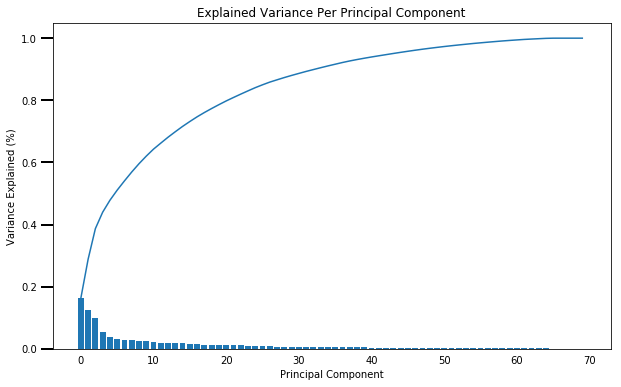

In [11]:
# Investigate the variance accounted for by each principal component.

scree_plot(pca)

In [68]:
for components in range(1, df_scaled.shape[1]):
    pca, X_pca = do_pca(components, df_scaled)
    component_check = pca_results(df_scaled, pca)
    if component_check["Explained Variance"].sum() > 0.85:
        break
        
num_comps = component_check.shape[0]
print("Using {} components, we can explain {}% of the variability in the original data.".format(num_comps,component_check['Explained Variance'].sum()))

Using 26 components, we can explain 0.8501% of the variability in the original data.


In [69]:
for components in range(1, df_scaled.shape[1]):
    pca, X_pca = do_pca(components, df_scaled)
    component_check = pca_results(df_scaled, pca)
    if component_check["Explained Variance"].sum() > 0.9:
        break
        
num_comps = component_check.shape[0]
print("Using {} components, we can explain {}% of the variability in the original data.".format(num_comps,component_check['Explained Variance'].sum()))

Using 34 components, we can explain 0.9052% of the variability in the original data.


In [16]:
for components in range(1, df_scaled.shape[1]):
    pca, X_pca = do_pca(components, df_scaled)
    component_check = pca_results(df_scaled, pca)
    if component_check["Explained Variance"].sum() > 0.95:
        break
        
num_comps = component_check.shape[0]
print("Using {} components, we can explain {}% of the variability in the original data.".format(num_comps,component_check['Explained Variance'].sum()*100))

Using 44 components, we can explain 95.10000000000001% of the variability in the original data.


In [12]:
# Re-apply PCA to the data while selecting for number of components to retain.

n_components = 44
pca, X_pca = do_pca(n_components=n_components, data=df_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

Since the Scree Plot didn't exhibit any prominent elbow, I had to manually enforce thresholds and check the number of components explaining decent percentage of variability. 

Finally I settled on 44 components which explain 95% of the variability. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [242]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

(44, 70)

In [13]:
df_components = pd.DataFrame(pca.components_, columns=df_scaled.keys())

In [14]:
def plot_weights(top_features):
    plt.figure(figsize=(10,6))
    scalar_points = [*range(len(top_features.keys()))]
    plt.bar(scalar_points, top_features.values)
    plt.xticks(scalar_points, top_features.keys().values, rotation="vertical")
    plt.show()

In [15]:
def prepare_and_plot(df, i, top_n):
    sorted_values = df.loc[i-1].sort_values()
    top_positive_features = sorted_values[-top_n:][::-1]
    top_negative_features = sorted_values[:top_n]
    
    plot_weights(top_positive_features)
    plot_weights(top_negative_features)
    return top_positive_features, top_negative_features

## First component

In [16]:
print("The variance explained by the first component is {}%".format(pca.explained_variance_ratio_[0]*100))

The variance explained by the first component is 16.295995211464096%


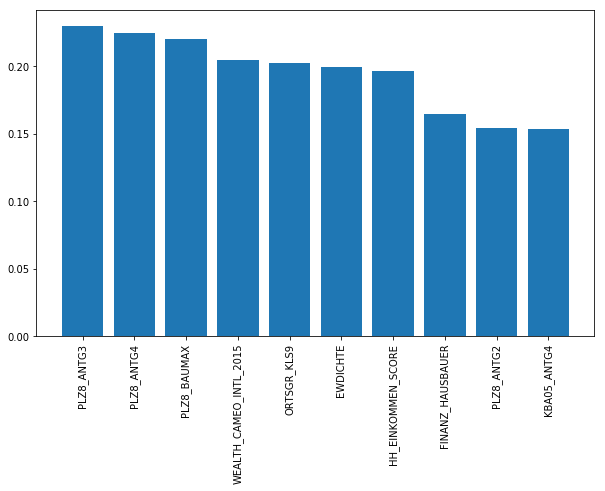

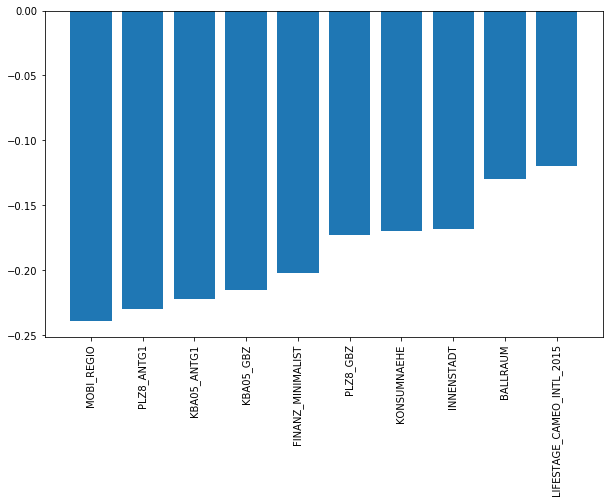

In [17]:
top_p1, top_n1 = prepare_and_plot(df_components, 1, 10)

## Second component

In [18]:
print("The variance explained by the second component is {}%".format(pca.explained_variance_ratio_[1]*100))

The variance explained by the second component is 12.536675893543874%


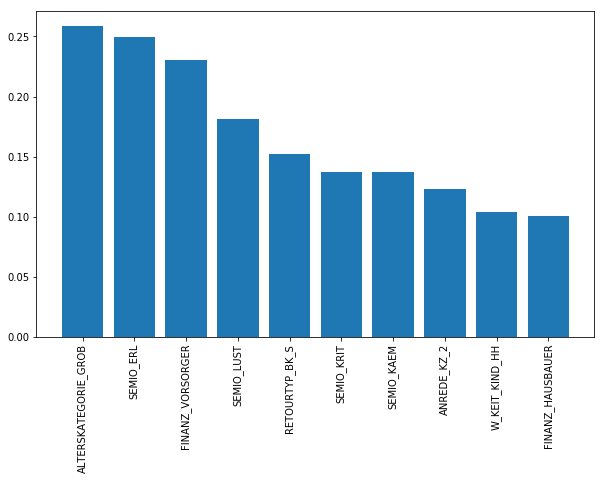

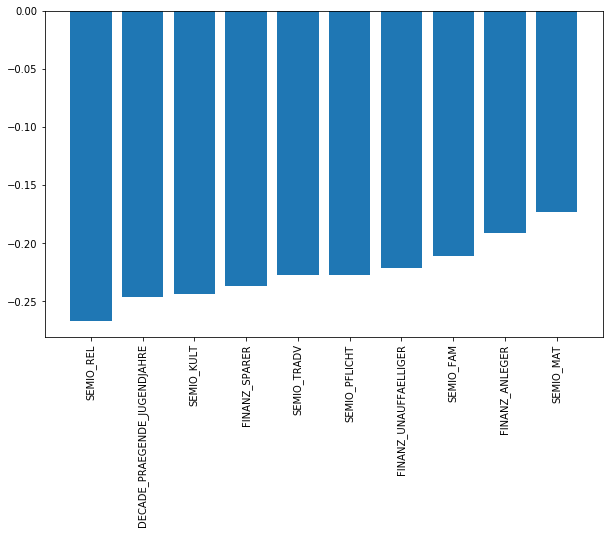

In [19]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

top_p2, top_n2 = prepare_and_plot(df_components, 2, 10)

## Third component

In [21]:
print("The variance explained by the third component is {}%".format(pca.explained_variance_ratio_[2]*100))

The variance explained by the third component is 9.856017515167402%


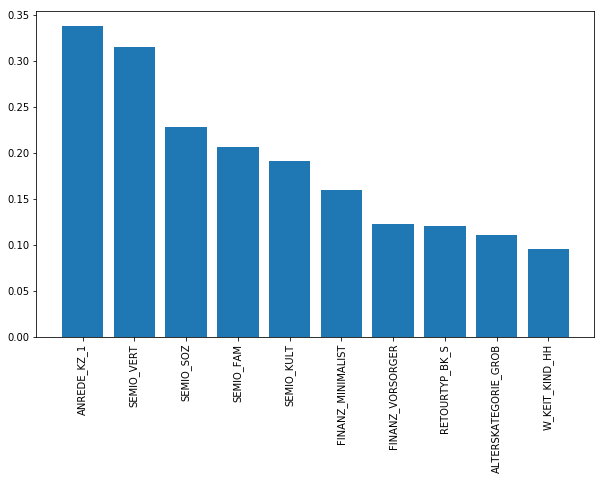

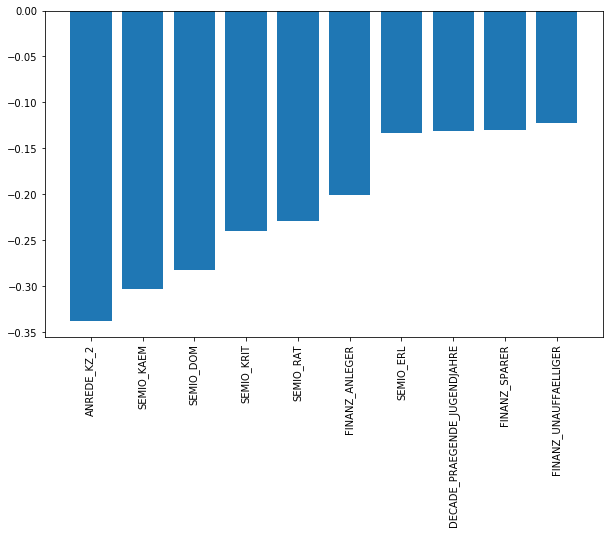

In [22]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

top_p3, top_n3 = prepare_and_plot(df_components, 3, 10)

In [246]:
important_features=np.array([])
for i in range(3):
    ind = np.argsort(pca.components_[i])
    important_features = np.hstack((important_features,df_scaled.columns.values[ind[:5]],df_scaled.columns.values[ind[-5:]]))

### Discussion 2.3: Interpret Principal Components

To interpret each principal component, examine the magnitude and the direction of coefficients of the original variables. The larger the absolute value of the coefficient, the more important the corresponding variable is in calculating the component. 


#### First component
The first component explained around 16% of the total variance. 

Here are the feature explanations of the top features:

| Top 5 positive features                                               | Top 5 negative features                                      |
|------------------------------------------------------------------------|---------------------------------------------------------------|
| **PLZ8_ANTG3**: Number of 6-10 family houses in the PLZ8 region            | **MOBI_REGIO**: Movement patterns                                 |
| **PLZ8_ANTG4**: Number of 10+ family houses in the PLZ8 region             | **PLZ8_ANTG1**: Number of 1-2 family houses in the PLZ8 region    |
| **PLZ8_BAUMAX**: Most common building type within the PLZ8 region          | **KBA05_ANTG1**: Number of 1-2 family houses in the microcell     |
| **WEALTH_CAMEO_INTL_2015**: How wealthy the household is in a range of 1-5 | **KBA05_GBZ**: Number of buildings in the microcell               |
| **ORTSGR_KLS9**: Size of community                                         | **FINANZ_MINIMALIST**: Financial typology, low financial interest |

The first component primarily associates with individuals likely to stay in densely populated regions with the common type of building being 6-10 & 10+ family houses. It dictates the size of the community in addition to how wealthy the people living in the community are. The individuals are likely to be less interested in financial services and their movements patterns are likely to be restrictive. 

#### Second component

The second component explained around 12.5% of the total vairance. 

Here are the feature explanations of the top features:

| Top 5 positive features                                          | Top 5 negative features                                             |
|------------------------------------------------------------------|---------------------------------------------------------------------|
| ALTERSKATEGORIE_GROB: Estimated age based on given name analysis | SEMIO_REL:  Personality typology, religious                         |
| SEMIO_ERL: Personality typology, event-oriented                  | DECADE_PRAEGENDE_JUGENDJAHRE: Dominating decade of a person's youth |
| FINANZ_VORSORGER: Financial typology, be prepared.               | SEMIO_KULT:  Personality typology, cultural-minded                  |
| SEMIO_LUST:  Personality typology, sensual-minded                | FINANZ_SPARER: Financial typology, money-saver                      |
| RETOURTYP_BK_S: Return type                                      | SEMIO_TRADV:  Personality typology, traditional-minded              |

This component has a huge association with the type of personality an individual has. According to these top features, it seems the individual is likely to be a cautious spender. This component measures long-term financial stability having made good decision for future savings. Also the other features dictate that individuals might be culturally and religiously inclined.


#### Third component

The third component explained around 10% of the total vairance. 

Here are the feature explanations of the top features:

| Top 5 positive features                           | Top 5 negative features                               |
|---------------------------------------------------|-------------------------------------------------------|
| ANREDE_KZ_1: Gender - male                        | ANREDE_KZ_2: Gender - female                          |
| SEMIO_VERT: Personality typology, dreamful        | SEMIO_KAEM:  Personality typology, combative attitude |
| SEMIO_SOZ: Personality typology, socially-minded  | SEMIO_DOM: Personality typology, dominant-minded      |
| SEMIO_FAM: Personality typology, family-minded    | SEMIO_KRIT: Personality typology, crticial-minded     |
| SEMIO_KULT: Personality typology, cultural-minded | SEMIO_RAT: Personality typology, rational             |

This component is greatly inclined towards personality traits in individuals. It talks about male individuals who are less family minded (since higher values indicate less family-mindedness). They are generally less dreamful, socially and culturally-inclined and more dominant and critical-minded. They tend to be rational and have a comabitve attitude. 

**References**:

* [Interpret PCA components](https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/multivariate/how-to/principal-components/interpret-the-results/key-results/)


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [23]:
X_pca.shape

(797426, 44)

In [ ]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

### KMeans object score() method

In [29]:
from sklearn.cluster import KMeans

def get_kmeans_avg_dist(X, n_clusters):   
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    model = kmeans.fit(X)
    
    # Average distance of samples from their respective centroids
    avg_distance = np.abs(model.score(X))/X.shape[0]
    return avg_distance

In [30]:
get_kmeans_avg_dist(X_pca, 3)

53.95719363273145

In [35]:
average_distances = list()
for i in range(1,11):
    avg_dist = get_kmeans_avg_dist(X_pca, i)
    average_distances.append(avg_dist)
    print("Average distance of samples from their respective centroids for {} clusters is {}"
          .format(i, np.around(avg_dist, 3)))

Average distance of samples from their respective centroids for 1 clusters is 66.536
Average distance of samples from their respective centroids for 2 clusters is 57.959
Average distance of samples from their respective centroids for 3 clusters is 53.957
Average distance of samples from their respective centroids for 4 clusters is 51.041
Average distance of samples from their respective centroids for 5 clusters is 48.694
Average distance of samples from their respective centroids for 6 clusters is 46.93
Average distance of samples from their respective centroids for 7 clusters is 45.356
Average distance of samples from their respective centroids for 8 clusters is 43.533
Average distance of samples from their respective centroids for 9 clusters is 42.423
Average distance of samples from their respective centroids for 10 clusters is 41.624


In [36]:
# As the number of clusters increase, the time taken to calculate the average distance keeps on increasing.
# Therefore running in incremental intervals to see how fast/slow the average distance goes on decreasing. 
for i in range(11, 16):
    avg_dist = get_kmeans_avg_dist(X_pca, i)
    average_distances.append(avg_dist)
    print("Average distance of samples from their respective centroids for {} clusters is {}"
          .format(i, np.around(avg_dist, 3)))

Average distance of samples from their respective centroids for 11 clusters is 40.844
Average distance of samples from their respective centroids for 12 clusters is 40.13
Average distance of samples from their respective centroids for 13 clusters is 39.656
Average distance of samples from their respective centroids for 14 clusters is 39.362
Average distance of samples from their respective centroids for 15 clusters is 38.97


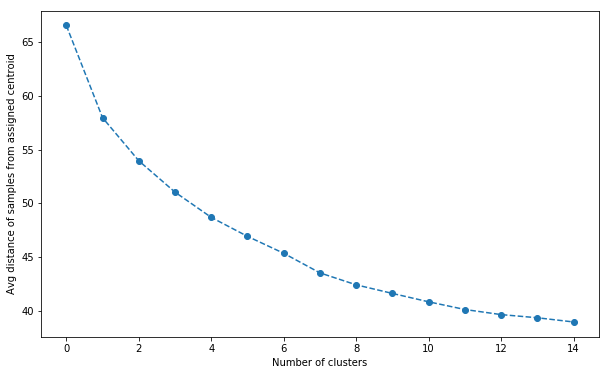

In [38]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=(10,6))
scalar_points = [*range(len(average_distances))]
plt.plot(scalar_points, average_distances, marker='o', linestyle='dashed')
plt.xlabel("Number of clusters")
plt.ylabel("Avg distance of samples from assigned centroid")
plt.show()

### Silhoutte score

In [48]:
from sklearn.metrics import silhouette_score
def get_silhouette_score(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)

    indices = kmeans.fit_predict(X)
    score = silhouette_score(X, indices, sample_size=20000, random_state=0)
    return score

In [49]:
score = get_silhouette_score(X_pca, 6)

In [50]:
score

0.1007470488957373

In [92]:
s_scores = list()
for i in range(2,11):
    score = get_silhouette_score(X_pca, i)
    s_scores.append(score)
    print("Silhouette score for {} clusters is {}"
          .format(i, np.around(score, 3)))
    

Silhouette score for 2 clusters is 0.128
Silhouette score for 3 clusters is 0.104
Silhouette score for 4 clusters is 0.112
Silhouette score for 5 clusters is 0.1
Silhouette score for 6 clusters is 0.101
Silhouette score for 7 clusters is 0.099
Silhouette score for 8 clusters is 0.104
Silhouette score for 9 clusters is 0.101
Silhouette score for 10 clusters is 0.097


In [93]:
for i in range(11,16):
    score = get_silhouette_score(X_pca, i)
    s_scores.append(score)
    print("Silhouette score for {} clusters is {}"
          .format(i, np.around(score, 3)))

Silhouette score for 11 clusters is 0.097
Silhouette score for 12 clusters is 0.094
Silhouette score for 13 clusters is 0.086
Silhouette score for 14 clusters is 0.083
Silhouette score for 15 clusters is 0.082


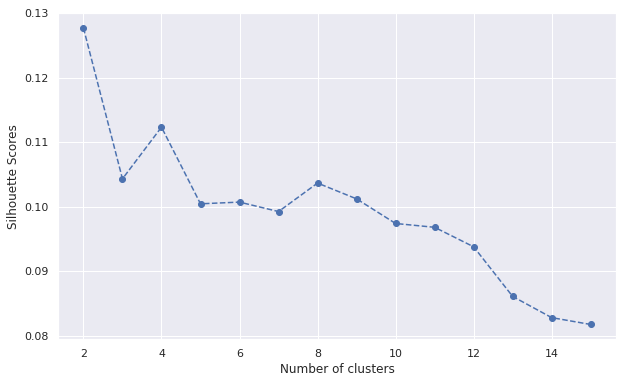

In [219]:
plt.figure(figsize=(10,6))
scalar_points = [*range(len(s_scores))]
scalar_points = [x.__add__(2) for x in scalar_points]
plt.plot(scalar_points, s_scores, marker='o', linestyle='dashed')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Scores")
plt.show()

In [64]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters)
indices = kmeans.fit_predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

To obtain the number of clusters, a scree plot was plotted using KMeans object `score()` method. It gives the average distance of a sample from its corresponding cluster centroid. 

Since the scree plot concerning the above method didn't portray a significant elbow, I further experimented with silhouette scores and found that, disregarding the initial spike on 2 clusters, there was a significant spike on 4 clusters and then at 8 and then it was a downhill journey. Since in the above method, the line graph began to show less significant improvement after 4 clusters, I went ahead with the same. 

Silhouette score measures the affinity of a sample to it's own cluster than to other clusters. Higher the value, better are the clusters.
#### NOTE: 
* The best value is 1 and the worst value is -1. 
* Values near 0 indicate overlapping clusters. 
* Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

**Referenes**: 

[Silhouette scores Sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [72]:
# Load in the customer demographics data.
customer = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

In [73]:
customer.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [74]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customer_clean = clean_data(customer, feat_info, 20)

50012 rows dropped.


In [86]:
for df_column in df.columns:
    if df_column in customer_clean.columns:
        continue
    else:
        print("False")

In [87]:
# Apply imputation transform
customer_imputed_array = imputer.transform(customer_clean)
customer_imputed = pd.DataFrame(customer_imputed_array, columns=customer_clean.columns.values)

# Apply scalar transformation
scaled_array = scaler.transform(customer_imputed)
customer_scaled = pd.DataFrame(scaled_array, columns=customer_clean.columns.values)

# Apply PCA dimensionality reduction
X_pca_customer = pca.transform(customer_scaled)

# Apply KMeans clustering
customer_indices = kmeans.predict(X_pca_customer)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [252]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

from collections import Counter, OrderedDict

In [186]:
def generate_proportions(labels):
    """
    
    Arguments:
        labels: An array of labels after kmeans predict() method. 
    
    Returns: 
        proportions_dict: A sorted-by-key dictionary with labels as the keys and proportion of labels out of the total
                          as the values. 
    """
    labels_count = Counter(labels)
    total = len(labels)

    label_proportion = {key: values / total for key, values in labels_count.items()}
    label_proportion_ordered = OrderedDict(sorted(label_proportion.items(), key=lambda t: t[0]))
    
    return label_proportion_ordered

In [187]:
customer_proportion = generate_proportions(customer_indices)
customer_proportion

OrderedDict([(0, 0.021575826037842416),
             (1, 0.5582180175091782),
             (2, 0.21325190624117482),
             (3, 0.20695425021180458)])

In [189]:
population_proportion = generate_proportions(indices)
population_proportion

OrderedDict([(0, 0.21845788825546195),
             (1, 0.2760695036279228),
             (2, 0.27237135483417896),
             (3, 0.23310125328243625)])

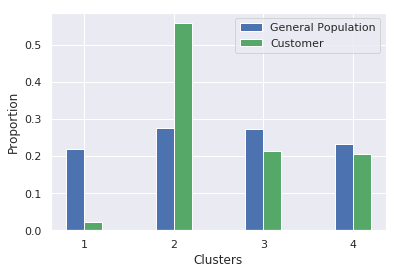

In [207]:
x=np.array(list(customer_proportion.keys()))

customer = list(customer_proportion.values())
population = list(population_proportion.values())
ax = plt.subplot(111)
ax.bar(x, population, width = 0.2, color = 'b', align = 'center', label = "General Population")
ax.bar(x + 0.2, customer, width = 0.2, color = 'g', align = 'center', label = "Customer")

x+=1
plt.xlabel("Clusters")
plt.xticks(np.arange(len(x))+0.1, x)
plt.ylabel("Proportion")
plt.legend()

### Over-representation of customer data compared to general population

In [253]:
cluster_number = 2

In [239]:
centers = kmeans.cluster_centers_
pca_inverse = pca.inverse_transform(centers)
scale_inverse = scaler.inverse_transform(pca_inverse)
scale_inverse.shape

(4, 70)

In [241]:
cluster_center_df = pd.DataFrame(scale_inverse,columns=customer_clean.columns).round(0)
cluster_center_df.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,...,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,OST_WEST_KZ_O,OST_WEST_KZ_W,MOVEMENT_PRAEGENDE_JUGENDJAHRE,DECADE_PRAEGENDE_JUGENDJAHRE,WEALTH_CAMEO_INTL_2015,LIFESTAGE_CAMEO_INTL_2015
0,2.0,2.0,4.0,2.0,4.0,4.0,4.0,0.0,2.0,3.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,4.0,2.0
1,3.0,4.0,2.0,4.0,2.0,3.0,2.0,0.0,2.0,4.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,2.0,3.0
2,3.0,3.0,3.0,4.0,3.0,3.0,3.0,0.0,2.0,3.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,2.0,3.0
3,3.0,3.0,2.0,4.0,2.0,2.0,4.0,0.0,2.0,4.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,4.0,3.0


In [254]:
cluster_center_df[important_features].loc[cluster_number-1]

MOBI_REGIO                      4.0
PLZ8_ANTG1                      3.0
KBA05_ANTG1                     2.0
KBA05_GBZ                       4.0
FINANZ_MINIMALIST               4.0
ORTSGR_KLS9                     4.0
WEALTH_CAMEO_INTL_2015          2.0
PLZ8_BAUMAX                     1.0
PLZ8_ANTG4                      0.0
PLZ8_ANTG3                      1.0
SEMIO_REL                       4.0
DECADE_PRAEGENDE_JUGENDJAHRE    3.0
SEMIO_KULT                      5.0
FINANZ_SPARER                   2.0
SEMIO_TRADV                     4.0
RETOURTYP_BK_S                  4.0
SEMIO_LUST                      4.0
FINANZ_VORSORGER                4.0
SEMIO_ERL                       4.0
ALTERSKATEGORIE_GROB            3.0
ANREDE_KZ_2                     0.0
SEMIO_KAEM                      2.0
SEMIO_DOM                       3.0
SEMIO_KRIT                      3.0
SEMIO_RAT                       3.0
SEMIO_KULT                      5.0
SEMIO_FAM                       5.0
SEMIO_SOZ                   

| Features and Explanation                                                                                                                                          | Value | Remark                                       |
|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------|:----------------------------------------------|
| MOBI_REGIO: Higher number indicates lower movement                                                                                                                | 4.0   | Low movement                                 |
| PLZ8_ANTG1: Higher number indicates higher share of 1-2 family houses in macrocell                                                                                | 3.0   | High share of 1-2 families                   |
| KBA05_ANTG1: Higher number indicates higher share of 1-2 family houses in microcell                                                                               | 2.0   | Average share                                |
| KBA05_GBZ: Number of buildings in the microcell; 5 being buildings greater than 23                                                                                | 4.0   | 17-22 buildings                              |
| FINANZ_MINIMALIST: Financial typology for the trait of low financial interest, where lower values are associated with very high scores for low financial interest | 4.0   | Low financial interest                       |
| ORTSGR_KLS9: Size of community; 1-9; 1 being < 2000 inhabitants and 9 being > 700000                                                                              | 4.0   | 10000-20000 inhabitants                      |
| WEALTH_CAMEO_INTL_2015: Indicates how wealthy the household is on a scale of 1-5; 1 being the most wealthy.                                                       | 2.0   | Prosperous household                         |
| PLZ8_BAUMAX: Most common building type within the PLZ8 region                                                                                                     | 1.0   | mainly 1-2 family homes                      |
| PLZ8_ANTG4: Number of 10+ family homes; Lower number is associated with lower share of 10+ family homes                                                           | 0.0   | No 10+ family homes                          |
| PLZ8_ANTG3: Number of 6-10 family homes; Lower number is associated with lower share of 6-10 family homes                                                         | 1.0   | Very low share of 6-10 family houses         |
| SEMIO_REL: Affinity levels for religious individuals where lower values indicate higher levels of affinity.                                                       | 4.0   | Average affinity to be religious             |
| DECADE_PRAEGENDE_JUGENDJAHRE: Represents the dominating decade of an individual. [40s = 0, 50s = 1, 60s = 2, 70s = 3, 80s = 4, 90s = 5]                           | 3.0   | Dominating decade of an individual was 70s   |
| SEMIO_KULT: Affinity levels for cultural-minded individuals where lower values indicate higher levels of affinity.                                                | 5.0   | Low affinity to be culturally inclined       |
| FINANZ_SPARER: Money saver; where lower values are associated with very high tendency of money saving.                                                            | 2.0   | High tendency to save money                  |
| SEMIO_TRADV: Affinity levels for tradional-minded individuals where lower values indicate higher levels of affinity.                                              | 4.0   | Average affinity for being traditional                        |
| RETOURTYP_BK_S: Type of returner; Lower values are associated with crazy shopping tendencies                                                                      | 4.0   | Conservative low returner shopper            |
| SEMIO_LUST: Affinity levels for sensual-minded individuals where lower values indicate higher levels of affinity.                                                 | 4.0   | Average affinity to mingle with opposite sex |
| FINANZ_VORSORGER: Indicates financial preparedness; Lower values correspond to high preparedness                                                                  | 4.0   | Low financial preparedness                   |
| SEMIO_ERL: Affinity levels for event-oriented individuals where lower values indicate higher levels of affinity.                                                  | 4.0   | Average affinity to attending events         |
| ALTERSKATEGORIE_GROB: Estimated age based on given name analysis.                                                                                                 | 3.0   | 46-60 years old                              |
| ANREDE_KZ_1: Gender; where 1 indicates male and 0 indicates female                                                                                                | 0.0   | Female                                       |
| SEMIO_KAEM: Affinity levels for combative attitude individuals where lower values indicate higher levels of affinity.                                             | 2.0   | Very high affinity to quarrel.               |
| SEMIO_DOM: Affinity levels for dominant-minded individuals where lower values indicate higher levels of affinity.                                                 | 3.0   | High affinity to be assertive and stubborn.  |
| SEMIO_KRIT: Affinity levels for critical-minded individuals where lower values indicate higher levels of affinity.                                                | 3.0   | High affinity for critical thinking          |
| SEMIO_RAT: Affinity levels for rational individuals where lower values indicate higher levels of affinity.                                                        | 3.0   | High affinity to take decisions rationally   |
| SEMIO_FAM: Affinity levels for family-minded individuals where lower values indicate higher levels of affinity.                                                   | 5.0   | Low affinity to prioritize family needs      |
| SEMIO_SOZ: Affinity levels for socially-minded individuals where lower values indicate higher levels of affinity.                                                 | 5.0   | Low affinity for social interactions         |
| SEMIO_VERT: Affinity levels for dreamful individuals where lower values indicate higher levels of affinity.                                                       | 6.0   | Very low affinity to dream                   |
| ANREDE_KZ_1: Gender; where 1 indicates male and 0 indicates female                                                                                                | 1.0   | Male                                         |

### Under-representation of customer data compared to general population

In [248]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster_number = 1

In [249]:
cluster_center_df[important_features].loc[cluster_number-1]

MOBI_REGIO                      2.0
PLZ8_ANTG1                      2.0
KBA05_ANTG1                     1.0
KBA05_GBZ                       2.0
FINANZ_MINIMALIST               2.0
ORTSGR_KLS9                     7.0
WEALTH_CAMEO_INTL_2015          4.0
PLZ8_BAUMAX                     3.0
PLZ8_ANTG4                      1.0
PLZ8_ANTG3                      2.0
SEMIO_REL                       6.0
DECADE_PRAEGENDE_JUGENDJAHRE    5.0
SEMIO_KULT                      5.0
FINANZ_SPARER                   4.0
SEMIO_TRADV                     5.0
RETOURTYP_BK_S                  3.0
SEMIO_LUST                      3.0
FINANZ_VORSORGER                2.0
SEMIO_ERL                       3.0
ALTERSKATEGORIE_GROB            2.0
ANREDE_KZ_2                     1.0
SEMIO_KAEM                      4.0
SEMIO_DOM                       5.0
SEMIO_KRIT                      4.0
SEMIO_RAT                       5.0
SEMIO_KULT                      5.0
SEMIO_FAM                       5.0
SEMIO_SOZ                   

| Features and Explanation                                                                                                                                          | Value | Remark                                      |
|-------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------|---------------------------------------------|
| MOBI_REGIO: Higher number indicates lower movement                                                                                                                | 2.0   | High movement                               |
| PLZ8_ANTG1: Higher number indicates higher share of 1-2 family houses in macrocell                                                                                | 2.0   | Average share of 1-2 families               |
| KBA05_ANTG1: Higher number indicates higher share of 1-2 family houses in microcell                                                                               | 1.0   | Lower share                                 |
| KBA05_GBZ: Number of buildings in the microcell; 5 being buildings greater than 23                                                                                | 2.0   | 3-4 buildings                               |
| FINANZ_MINIMALIST: Financial typology for the trait of low financial interest, where lower values are associated with very high scores for low financial interest | 2.0   | Very Low financial interest                 |
| ORTSGR_KLS9: Size of community; 1-9; 1 being < 2000 inhabitants and 9 being > 700000                                                                              | 7.0   | 100000-300000 inhabitants                   |
| WEALTH_CAMEO_INTL_2015: Indicates how wealthy the household is on a scale of 1-5; 1 being the most wealthy.                                                       | 4.0   | Less Affluent household                     |
| PLZ8_BAUMAX: Most common building type within the PLZ8 region                                                                                                     | 3.0   | mainly 6-10 family homes                    |
| PLZ8_ANTG4: Number of 10+ family homes; Lower number is associated with lower share of 10+ family homes                                                           | 1.0   | Lower share of 10+ family homes             |
| PLZ8_ANTG3: Number of 6-10 family homes; Lower number is associated with lower share of 6-10 family homes                                                         | 2.0   | Average share of 6-10 family houses         |
| SEMIO_REL: Affinity levels for religious individuals where lower values indicate higher levels of affinity.                                                       | 6.0   | Very low affinity to be religious           |
| DECADE_PRAEGENDE_JUGENDJAHRE: Represents the dominating decade of an individual. [40s = 0, 50s = 1, 60s = 2, 70s = 3, 80s = 4, 90s = 5]                           | 5.0   | Dominating decade of an individual was 90s  |
| SEMIO_KULT: Affinity levels for cultural-minded individuals where lower values indicate higher levels of affinity.                                                | 5.0   | Low affinity to be culturally inclined      |
| FINANZ_SPARER: Money saver; where lower values are associated with very high tendency of money saving.                                                            | 4.0   | Low tendency to save money                  |
| SEMIO_TRADV: Affinity levels for tradional-minded individuals where lower values indicate higher levels of affinity.                                              | 5.0   | Low affinity to be traditional              |
| RETOURTYP_BK_S: Type of returner; Lower values are associated with crazy shopping tendencies                                                                      | 3.0   | Incentive-receptive normal-returner shopper |
| SEMIO_LUST: Affinity levels for sensual-minded individuals where lower values indicate higher levels of affinity.                                                 | 3.0   | High affinity to mingle with opposite sex   |
| FINANZ_VORSORGER: Indicates financial preparedness; Lower values correspond to high preparedness                                                                  | 2.0   | High financial preparedness                 |
| SEMIO_ERL: Affinity levels for event-oriented individuals where lower values indicate higher levels of affinity.                                                  | 3.0   | High affinity to attending events           |
| ALTERSKATEGORIE_GROB: Estimated age based on given name analysis.                                                                                                 | 2.0   | 30-45 years old                             |
| ANREDE_KZ_1: Gender; where 1 indicates male and 0 indicates female                                                                                                | 1.0   | Male                                        |
| SEMIO_KAEM: Affinity levels for combative attitude individuals where lower values indicate higher levels of affinity.                                             | 4.0   | Average affinity to quarrel.                |
| SEMIO_DOM: Affinity levels for dominant-minded individuals where lower values indicate higher levels of affinity.                                                 | 5.0   | Low affinity to be assertive and stubborn.  |
| SEMIO_KRIT: Affinity levels for critical-minded individuals where lower values indicate higher levels of affinity.                                                | 4.0   | Average affinity for critical thinking      |
| SEMIO_RAT: Affinity levels for rational individuals where lower values indicate higher levels of affinity.                                                        | 5.0   | Low affinity to take decisions rationally   |
| SEMIO_FAM: Affinity levels for family-minded individuals where lower values indicate higher levels of affinity.                                                   | 5.0   | Low affinity to prioritize family needs     |
| SEMIO_SOZ: Affinity levels for socially-minded individuals where lower values indicate higher levels of affinity.                                                 | 5.0   | Low affinity for social interactions        |
| SEMIO_VERT: Affinity levels for dreamful individuals where lower values indicate higher levels of affinity.                                                       | 4.0   | Average affinity to pursue dream            |
| ANREDE_KZ_1: Gender; where 1 indicates male and 0 indicates female                                                                                                | 0.0   | Female                                      |

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

#### Over-representation of customer data compared to general population

Cluster 2 seems to be over represented by the customer data which suggests that the individuals in this cluster of general population are more likely to be converted into customers. Most of the individuals seem to be people in age range 46-60 years old. Their dominating decade being the 1970s supports this fact. They seem to be settled in fairly less populated regions surrounded with major share of 1-2 family houses and very less or non-existent 6-10 family houses. They seem to be enjoying wealthy households.

As far as finance goes, these individuals seem to care less about spending, being a conservative shopper. Even though they have low financial interest, they have a high tendency to save money. 

Since they have passed their dominating decade, they seem to have a low affinity for pursuing their dreams, overall social interactions. They care less about family needs and are less culturally and religiously inclined. These individuals partake much less in traditions and events than their peers. Though they seem to be more grumpy and assertive, they indulge in rational decision-making and critical thinking. 

#### Under-representation of customer data compared to general population

Cluster 1 under represents the customer data which suggests that the individuals in corresponding general population will be harder to convert into customers.
These individuals seem to be in their 30s/40s, their dominating decade being 1990s. They reside in densely populated regions with a high share (6-10) of families living as a community. They are highly volatile in terms of movement and come from less affluent households (rural areas). 

Even though they don't have much financial interest and are also not interested in saving money, they have high financial preparedness. They are more likely to attend events and mingle with the opposite sex. They seem to be interested in shopping and return based on certain incentives. 

Low priority to family and low interest in social interactions are some of their characteristics. They tend to be less assertive and more open minded. They seem to be more inclined towards unorthodox behaviour and less inclined towards culture and traditions. 

#### Clusters 3 and 4

These clusters suggest that the company's customer base is universal and are catering towards the right people.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.